In [1]:
import data_cleaning as dc
import find_optimal_clusters as foc
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

Zanim rozpoczniemy analize naszego zbioru załadujmy dane i wyczyścmy je korzystając z pliku data_cleaning

In [2]:
df_loaded = pd.read_json('cocktail_dataset.json')
df = dc.clean_data(df_loaded)

Na początek zwizualizujmy dane odnośnie koktajli - jakie są kategorie koktajli, jakich szklanek się używa oraz ile używa się składników

In [3]:
ingredient_counts = df['ingredient_count'].value_counts().sort_index()
category_counts = df_loaded['category'].value_counts()
glass_counts = df_loaded['glass'].value_counts()

def plot_data(plot_type):
    """
    Funckja do rysowania wykresów
    Input : rodzaj wykresu zczytany z dropdown menu
    Output : wykres
    """
    plt.figure(figsize=(10, 6))
    
    if plot_type == 'Ilość składników w drinkach':
        plt.bar(ingredient_counts.index, ingredient_counts.values, color='skyblue')
        plt.title('Rozkład ilości składników w drinkach')
        plt.xlabel('Ilość składników')
        plt.ylabel('Ilość Drinków')
        
    elif plot_type ==  'Ilość drinków w kategoriach':
        plt.bar(category_counts.index, category_counts.values, color='salmon')
        plt.title('Rozkład kategorii drinków')
        plt.xlabel('Kategoria')
        plt.ylabel('Ilość Drinków')
        
    elif plot_type == 'Ilość drinków w rodzajach szklanek':
        plt.bar(glass_counts.index, glass_counts.values, color='lightgreen')
        plt.title('Rozkład szklanek')
        plt.xlabel('Rodzaj szklanki')
        plt.ylabel('Ilość Drinków')
        plt.xticks(rotation=45)
        
    plt.grid(axis='y', linestyle='--')
    plt.show()

interact(plot_data, plot_type=['Ilość składników w drinkach', 'Ilość drinków w kategoriach', 'Ilość drinków w rodzajach szklanek'])

interactive(children=(Dropdown(description='plot_type', options=('Ilość składników w drinkach', 'Ilość drinków…

<function __main__.plot_data(plot_type)>

Zobaczmy więc jak algorytmy klastrujące rozdzielają nasze koktajle do grup oraz oceńmy jak dobrze dany algorytm rozdziela koktajle na grupy. Zrobimy to używając 3 metryk: <br>
Silhoutte Score powie nam jak dobrze obiekty pasują do swoich klastrów (skala - im wyżej tym lepiej) <br>
Davies-Bouldin Index powie nam jak dobrze klastry są od siebie odseparowane (skala - im mniej tym lepiej) <br>
Calinski-Harabasz Index powie nam jak ma się wariancja wewnatrz klastrów do wariancji między klastrami (skala - im wyżej tym lepiej) <br>
Wykres jest interaktywny więc można zapoznać się z różnymi wynikami. <br>
Aby zróżnicować wyniki zalecane jest usunięcie argumentu random_state podczas definiowania algorytmu.

In [4]:
# interactive plot
def interactive_clustering(n_clusters, algorithm, scaler):
    """
    Funkcja do interaktywnych wykresów klastrowania
    Wejścia: wartości pobrane z widgetów (liczba klastrów, wybrany algorytm, czy standaryzować dane)
    Wyjścia: wykres algorytmu klastrowania
    """
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=1)
    elif algorithm == 'Spectral Clustering':
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
    
    # an option to disable the standarization (we only have 1 feature scalable to points higher than 1 so one may not find it necessary)
    if scaler:
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=10) 
        df_pca = pca.fit_transform(df_scaled)

    # Dimensionality reduction (otherwise we have 100+ columns)
    else:
        pca = PCA(n_components=10) 
        df_pca = pca.fit_transform(df)

    labels = model.fit_predict(df_pca)
    sil_score = silhouette_score(df_pca, labels)
    dbi_score = davies_bouldin_score(df_pca, labels)
    ch_score = calinski_harabasz_score(df_pca, labels)

    print(f"Dla {n_clusters} klastrów, wyniki: \nSilhouette : {sil_score}\nDavies Bouldin : {dbi_score}\nCalinski Harabasz : {ch_score}")
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Kompnent główny 1')
    plt.ylabel('Komponent główny 2')
    plt.title(f'{algorithm} z {n_clusters} klastrami')
    plt.show()

algorithm_widget = widgets.Dropdown(
    options=['KMeans', 'Spectral Clustering'],
    value='KMeans',
    description='Algorithm:',
)

n_clusters_widget = widgets.IntSlider(
    value=5,
    min=2,
    max=15,
    step=1,
    description='Klastry'
)

scaler_widget = widgets.Checkbox(
    value=True,
    description='Standaryzowanie Danych',
)

interact(interactive_clustering, n_clusters=n_clusters_widget, algorithm=algorithm_widget, scaler=scaler_widget)

# interesting note - the data seems much more readable when it is not standarized and spectral clustering seems to work better

interactive(children=(IntSlider(value=5, description='Klastry', max=15, min=2), Dropdown(description='Algorith…

<function __main__.interactive_clustering(n_clusters, algorithm, scaler)>

Na koniec zobaczmy, jak grupowane są nasze dane na bazie najbardziej optymalnego podzialu algorytmu k-means

Dla najlepszej ilości klastrów - 2, wyniki: 
Silhouette : 0.2629284936633282
Davies Bouldin : 2.0923008360615194
Calinski Harabasz : 13.248024457846096


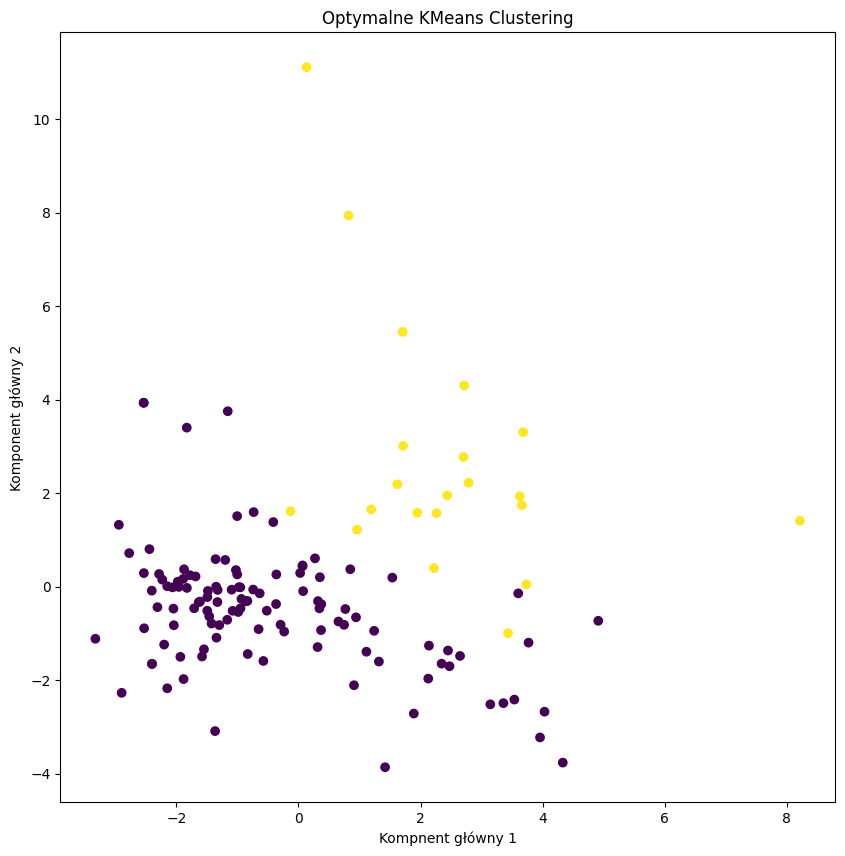

In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_scaled)


best_k = foc.find_optimal_clusters_kmeans(df_pca, 10, 1)

kmeans = KMeans(n_clusters=best_k)
labels = kmeans.fit_predict(df_pca)
sil_score = silhouette_score(df_pca, labels)
dbi_score = davies_bouldin_score(df_pca, labels)
ch_score = calinski_harabasz_score(df_pca, labels)
print(f"Dla najlepszej ilości klastrów - {best_k}, wyniki: \nSilhouette : {sil_score}\nDavies Bouldin : {dbi_score}\nCalinski Harabasz : {ch_score}")
df['cluster'] = labels
plt.figure(figsize=(10, 10))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Kompnent główny 1')
plt.ylabel('Komponent główny 2')
plt.title('Optymalne KMeans Clustering')
plt.show()


In [8]:
def plot_data(plot_type):
    """
    Funckja do rysowania wykresów
    Input : rodzaj wykresu zczytany z dropdown menu
    Output : wykres
    """
    
    if plot_type == 'Rozkład koktajli w klastrach':
        category_columns = df.columns[df.columns.isin(df_loaded['category'])]
        cluster_category_counts = df.groupby('cluster')[category_columns].sum()
        cluster_category_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black', figsize=(12, 10))
        plt.title('Liczba drinków z każdej kategorii w poszczególnych klastrach')
        plt.xlabel('Klaster')
        plt.ylabel('Liczba drinków')
        plt.legend(title='Kategoria koktajlu',loc='upper right')

        
    elif plot_type ==  'Rozkład szklanek w klastrach':
        glass_columns = df.columns[df.columns.isin(df_loaded['glass'])]
        cluster_glass_counts = df.groupby('cluster')[glass_columns].sum()
        cluster_glass_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black', figsize=(12, 10))
        plt.title('Liczba szklanek z każdej kategorii w poszczególnych klastrach')
        plt.xlabel('Klaster')
        plt.ylabel('Liczba szklanek')
        plt.legend(title='Rodzaj szklanki',loc='upper right')
        
    elif plot_type == 'Rozkład grup składników w klastrach':
        ingredient_counts = df.groupby(['cluster', 'ingredient_count']).size().unstack(fill_value=0)
        ingredient_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black', figsize=(12, 10))
        plt.title('Liczba koktajli podzielona na ilość składników w klastrach')
        plt.xlabel('Klaster')
        plt.ylabel('Liczba koktajli')
        plt.legend(title='N-składnikowe koktajle',loc='upper right')


    plt.grid(axis='y', linestyle='--')
    plt.show()

interact(plot_data, plot_type=['Rozkład grup składników w klastrach', 'Rozkład koktajli w klastrach', 'Rozkład szklanek w klastrach'])

interactive(children=(Dropdown(description='plot_type', options=('Rozkład grup składników w klastrach', 'Rozkł…

<function __main__.plot_data(plot_type)>